In [1]:
#!pip install wordcloud
#!pip install nltk
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

In [68]:
dataset = pd.read_csv('DataSet_CovidTweets2.csv')
dataset.head(15)

,Id,Tweet,Label
0,1,Our daily update is published. States reported...,0.0
1,2,Alfalfa is the only cure for COVID-19.,1.0
2,3,President Trump Asked What He Would Do If He W...,1.0
3,4,States reported 630 deaths. We are still seein...,0.0
4,5,This is the sixth time a global health emergen...,0.0
5,6,Low #vitaminD was an independent predictor of ...,0.0
6,7,A common question: why are the cumulative outc...,0.0
7,8,The government should consider bringing in any...,0.0
8,9,Our daily update is published. We’ve now track...,0.0
9,10,Breakdown of testing: 4 air crew 97 hotel &amp...,0.0


In [180]:
dataset['Label'].value_counts()
dataset.fillna(dataset.mean())
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset = dataset.dropna()

In [181]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139 entries, 0 to 2138
Data columns (total 3 columns):
Id       2139 non-null int64
Tweet    2139 non-null object
Label    2139 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 66.8+ KB


In [182]:
totalDataset = 1119 + 1020
trainingSet, testingSet = list(), list()
for i in range(dataset.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainingSet += [i]
    else:
        testingSet += [i]
trainData = dataset.iloc[trainingSet]
testData = dataset.iloc[testingSet]

In [184]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139 entries, 0 to 2138
Data columns (total 3 columns):
Id       2139 non-null int64
Tweet    2139 non-null object
Label    2139 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 66.8+ KB


In [185]:
trainData['Label'].value_counts()

0.0    1100
1.0    1003
Name: Label, dtype: int64

In [187]:
trainData.head()

,Id,Tweet,Label
0,1,Our daily update is published. States reported...,0.0
1,2,Alfalfa is the only cure for COVID-19.,1.0
2,3,President Trump Asked What He Would Do If He W...,1.0
3,4,States reported 630 deaths. We are still seein...,0.0
5,6,Low #vitaminD was an independent predictor of ...,0.0


In [189]:
testData['Label'].value_counts()

0.0    19
1.0    17
Name: Label, dtype: int64

In [190]:
testData.head()

,Id,Tweet,Label
4,5,This is the sixth time a global health emergen...,0.0
72,73,Facebook post that compares deaths in Italy du...,1.0
82,83,Your household plan for #COVID19 should includ...,0.0
118,119,"#coronavirus ""You can not buy anything with th...",1.0
124,125,Social gatherings of more than six people will...,0.0


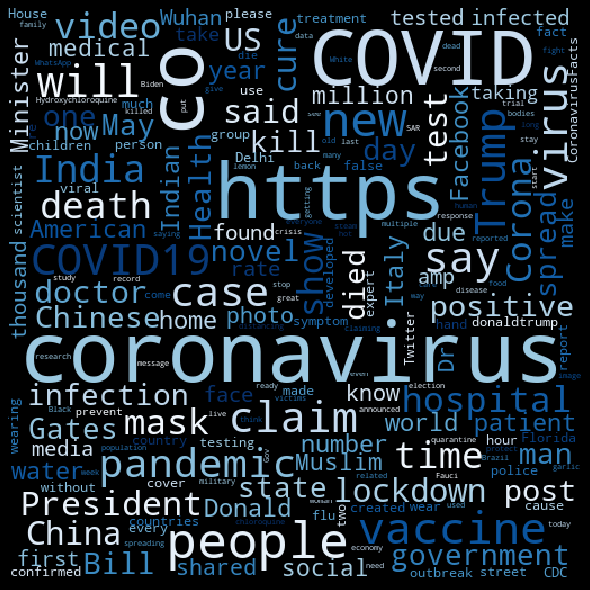

In [191]:
fake_words = ' '.join(list(dataset[dataset['Label'] == 1]['Tweet']))
fake_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(fake_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(fake_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

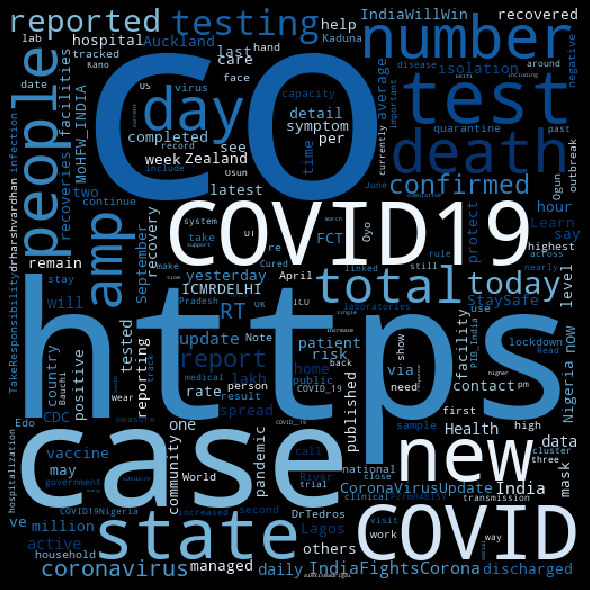

In [192]:
real_words = ' '.join(list(dataset[dataset['Label'] == 0]['Tweet']))
real_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(real_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(real_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [193]:

def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [194]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['Tweet'], trainData['Label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() 
                         
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [195]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [196]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['Tweet'])
metrics(testData['Label'], preds_tf_idf)

Precision:  0.8421052631578947
Recall:  0.9411764705882353
F-score:  0.8888888888888888
Accuracy:  0.8888888888888888


In [197]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['Tweet'])
metrics(testData['Label'], preds_bow)

Precision:  0.68
Recall:  1.0
F-score:  0.8095238095238095
Accuracy:  0.7777777777777778


In [198]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [199]:
from sklearn.model_selection import train_test_split
np.nan_to_num('Tweet')
np.nan_to_num('Label')
# pd.DataFrame('Tweet').fillna()
A_training, A_testing, b_training, b_testing = train_test_split(dataset['Tweet'],dataset['Label'],test_size=0.1, random_state=1337)

In [200]:
A_testing.shape

(214,)

In [201]:
from sklearn.feature_extraction.text import CountVectorizer
vector_counting = CountVectorizer(ngram_range=(1,2))

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectortraining = vector.fit_transform(A_training)
vectortesting = vector.transform(A_testing)

In [203]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
linearclassification = svm.SVC(kernel='linear')
zerotime = time.time()
linearclassification.fit(vectortraining, b_training)
firsttime = time.time()
predictlinear = linearclassification.predict(vectortesting)
secondtime = time.time()
trainingtime = firsttime-zerotime
predictiontime = secondtime-firsttime

print("Training time: %fs; Prediction time: %fs" % (trainingtime, predictiontime))
evaluationrep = classification_report(b_testing, predictlinear)

Training time: 0.330034s; Prediction time: 0.031336s


In [204]:
print(evaluationrep)

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       110
         1.0       0.96      0.90      0.93       104

    accuracy                           0.93       214
   macro avg       0.94      0.93      0.93       214
weighted avg       0.94      0.93      0.93       214



In [205]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
import time
from sklearn.metrics import classification_report
zerotime = time.time()
rf_model.fit(vectortraining, b_training)
firsttime = time.time()
predictlinear = rf_model.predict(vectortesting)
secondtime = time.time()
trainingtime = firsttime-zerotime
predictiontime = secondtime-firsttime

print("Training time: %fs; Prediction time: %fs" % (trainingtime, predictiontime))
evaluationrep = classification_report(b_testing, predictlinear)


Training time: 0.502298s; Prediction time: 0.012629s


In [206]:
print(evaluationrep)

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       110
         1.0       0.91      0.91      0.91       104

    accuracy                           0.92       214
   macro avg       0.92      0.92      0.92       214
weighted avg       0.92      0.92      0.92       214



In [207]:
from sklearn.ensemble import VotingClassifier

classf1 = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
classf2 = svm.LinearSVC()
classf3 = MultinomialNB()


eclassf = VotingClassifier(estimators=[('RF', classf1), ('svc', classf2), ('mnb', classf3)])

for clf, label in zip([classf1, classf2, classf3, eclassf], ['Random Forest', 'Linear SVC', 'Multinomial NB', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy = accuracy_summary(checker_pipeline, A_training, b_training, A_testing, b_testing)

Validation result for Random Forest
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
null accuracy: 51.40%
accuracy score: 89.72%
model is 38.32% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
null accuracy: 51.40%
accuracy scor

In [225]:
inp = process_message('Vaccine is the only cure for COVID-19.')
sc_tf_idf.classify(inp)


True

In [212]:
inp = process_message('States reported 630 deaths. We are still seeing a solid national decline')
sc_tf_idf.classify(inp)

False

In [11]:
from matplotlib import pyplot as plt
import math
import numpy as np
%matplotlib inline

In [36]:
algo = ['TF-IDF', 'BOW', 'SVM', 'Random Forest']
acc = [88.88, 77.77, 94, 92]

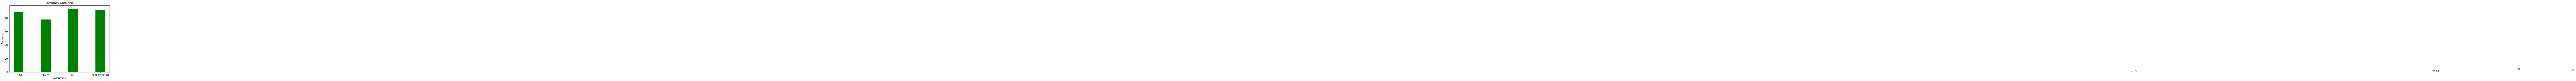

In [69]:
fig = plt.figure()
algo = ['TF-IDF', 'BOW', 'SVM', 'Random Forest']
acc = [88.88, 77.77, 94, 92]
ax = fig.add_axes([0,0,1,1])
ax.bar( algo, aax.set_title('Accuracy Obtained')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Algorithms')cc, color ='g',width = 0.35)

for index, value in enumerate(acc):
    plt.text(value, index,
             str(value))
plt.show()


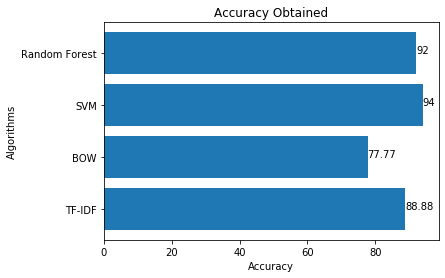

In [80]:
x = ['TF-IDF', 'BOW', 'SVM', 'Random Forest']
y = [88.88, 77.77, 94, 92]
plt.barh(x, y)
plt.xlabel("Accuracy")
plt.ylabel("Algorithms")
plt.title("Accuracy Obtained")


for index, value in enumerate(y):
    plt.text(value, index, str(value))


In [34]:
plt.show()